In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys

PROJECT_ROOT = '/content/drive/MyDrive/perceptual-vits-fashion-forecasting'
sys.path.append(os.path.join(PROJECT_ROOT, 'src'))

from data.process_visuelle import process_visuelle

results_process_visuelle = process_visuelle(
    season='AW19',
    split_method='standard',
    melt_data=True,
    project_root=PROJECT_ROOT
)

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# --------------------
# Load data via root
# --------------------
train_data = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        'datasets',
        'visuelle2',
        'processed_data',
        'melt_true_aw19_standard_split',
        'visuelle2_train.csv'
    )
)

val_data = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        'datasets',
        'visuelle2',
        'processed_data',
        'melt_true_aw19_standard_split',
        'visuelle2_val.csv'
    )
)

# -------------------------
# Feature groups (technical)
# -------------------------
feature_groups = {
    'year_int': ['year'],
    'year_dummies': [c for c in train_data.columns if c.startswith('year_')],
    'season_dummies': [c for c in train_data.columns if c.startswith('fs_')],
    'price_float': ['price'],
    'category_dummies': [c for c in train_data.columns if c.startswith('cat_')],
    'color_dummies': [c for c in train_data.columns if c.startswith('col_')],
    'fabric_dummies': [c for c in train_data.columns if c.startswith('fab_')],
    'store_int': ['store_int'],
    'store_dummies': [c for c in train_data.columns if c.startswith('store_') and c != 'store_int'],
    'week_dummies': [c for c in train_data.columns if c.startswith('week_')],
}

# --------------------------------
# Thesis-ready group display labels
# --------------------------------
GROUP_LABELS = {
    'year_int': 'Release year (numeric)',
    'year_dummies': 'Release year (dummy varaibles)',
    'season_dummies': 'Fashion season (dummy varaibles)',
    'price_float': 'Item price',
    'category_dummies': 'Product category (dummy varaibles)',
    'color_dummies': 'Primary color (dummy varaibles)',
    'fabric_dummies': 'Fabric type (dummy varaibles)',
    'store_int': 'Number of stores selling the item',
    'store_dummies': 'Store identifiers (dummy varaibles)',
    'week_dummies': 'Week within sales horizon (dummy varaibles)',
}

TARGET = 'sales_sum'

def _resolve_groups(df, groups):
    out = {}
    for name, cols in groups.items():
        keep = [c for c in cols if c in df.columns]
        if keep:
            out[name] = keep
    return out

def _flatten(groups):
    cols = []
    for v in groups.values():
        cols.extend(v)
    seen = set()
    ordered = []
    for c in cols:
        if c not in seen:
            seen.add(c)
            ordered.append(c)
    return ordered

def group_permutation_importance(train_df, val_df, groups, target=TARGET,
                                 n_perm=5, random_state=123):
    rng = np.random.default_rng(random_state)
    groups = _resolve_groups(train_df, groups)

    X_train = train_df[_flatten(groups)]
    y_train = train_df[target].astype(float)
    X_val   = val_df[_flatten(groups)]
    y_val   = val_df[target].astype(float)

    model = RandomForestRegressor(
        n_estimators=400,
        random_state=123,
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    base_mse = mean_squared_error(y_val, model.predict(X_val))

    rows = []
    for gname, gcols in groups.items():
        deltas = []
        for _ in range(n_perm):
            Xp = X_val.copy()
            perm = rng.permutation(len(Xp))
            Xp[gcols] = Xp[gcols].iloc[perm].reset_index(drop=True).values
            mse_p = mean_squared_error(y_val, model.predict(Xp))
            deltas.append(mse_p - base_mse)

        rows.append({
            'group': gname,
            'n_cols': len(gcols),
            'importance_delta_mse': float(np.mean(deltas)),
            'std': float(np.std(deltas))
        })

    out = (
        pd.DataFrame(rows)
        .sort_values('importance_delta_mse', ascending=False)
        .reset_index(drop=True)
    )
    return out

Mounted at /content/drive


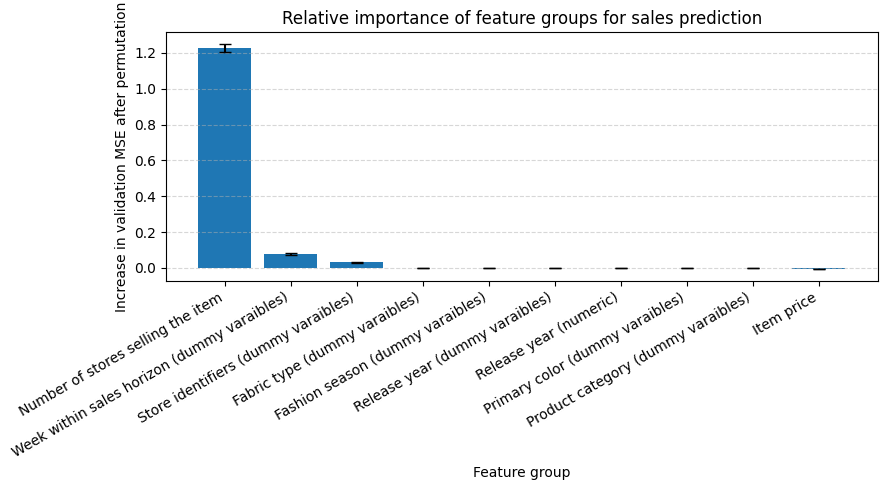

In [2]:
import matplotlib.pyplot as plt
import os

# -----------------------------
# Compute permutation importance
# -----------------------------
imp = group_permutation_importance(
    train_df=train_data,
    val_df=val_data,
    groups=feature_groups,
    target=TARGET,
    n_perm=5,
    random_state=123
)

# Apply thesis-ready labels
imp['group_label'] = imp['group'].map(GROUP_LABELS)

# -----------------------------
# Plot and save figure
# -----------------------------
plt.figure(figsize=(9, 5))
plt.bar(
    imp['group_label'],
    imp['importance_delta_mse'],
    yerr=imp['std'],
    capsize=4
)

plt.xticks(rotation=30, ha='right')
plt.xlabel('Feature group')
plt.ylabel('Increase in validation MSE after permutation')
plt.title('Relative importance of feature groups for sales prediction')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

viz_dir = os.path.join(PROJECT_ROOT, 'visualizations')
os.makedirs(viz_dir, exist_ok=True)

fig_path = os.path.join(
    viz_dir,
    'group_permutation_importance_sales_prediction.png'
)

plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()